# Задание 1.2

In [1]:
import pandas as pd
import numpy as np
from statistics import median
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

%load_ext lab_black

### Задача медленно превращается в маленькое, но весьма аналитическое исследование.

In [2]:
# загрузим данные
df_center = pd.read_csv("/home/sk27/repo/eremeev/test_projects/call_center_data.csv")

In [3]:
# преобразуем формат данных о дате и времени совершения операции
df_center["datetime"] = df_center["date"] + " " + df_center["time"]
df_center["datetime"] = df_center["datetime"].astype("datetime64[ns]")
df_center.drop(["date", "time"], axis=1, inplace=True)
df_center.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196782 entries, 0 to 196781
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   action    196782 non-null  int64         
 1   user_id   196782 non-null  int64         
 2   datetime  196782 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.5 MB


Тут важное замечание: ранее я исходил из того, что время, прошедшее между последовательными операциями  пользователя, это время выполнения **первой** операции. Но это не так. Время, прошедшее между двумя операциями пользователя, это время выполнения **второй** операции.

In [4]:
# Сгруппируем датафрейм по пользователю, посчитав уникальные значения datetime
a = df_center.groupby("user_id")["datetime"].value_counts().reset_index(name="t")

# Выведем строки, в которых количество уникальных значений > 1
a.loc[a["t"] > 1]

,user_id,datetime,t
32532,38830,2018-01-03 09:33:26,2
32533,38830,2018-01-03 14:10:03,2
32534,38830,2018-01-03 14:11:13,2
32535,38830,2018-01-03 14:11:59,2
32536,38830,2018-01-03 14:12:47,2
...,...,...,...
84828,39037,2018-01-17 16:00:17,2
84829,39037,2018-01-18 12:07:58,2
84830,39037,2018-01-22 15:33:32,2
84831,39037,2018-01-23 11:13:57,2


In [5]:
# например
df_center[(df_center.user_id == 38830) & (df_center.datetime == "2018-01-03 09:33:26")]

,action,user_id,datetime
1454,14,38830,2018-01-03 09:33:26
1455,2006,38830,2018-01-03 09:33:26


In [6]:
# чем же занимался юзер 38830 прежде, чем завершить одновременно два действия?
df_center[1450:1457]
# в 2018-01-03 09:33:23 этот гений многозадачности завершил действие 14, а спустя 3 секунды в его умелых руках уже совершены действия 14 и 2006. Нет, ну молодец же!

,action,user_id,datetime
1450,2010,39217,2018-01-03 09:33:15
1451,2010,39217,2018-01-03 09:33:19
1452,14,38830,2018-01-03 09:33:23
1453,2010,39217,2018-01-03 09:33:24
1454,14,38830,2018-01-03 09:33:26
1455,2006,38830,2018-01-03 09:33:26
1456,14,38830,2018-01-03 09:33:28


Молодец-то он, конечно, молодец, спору нет. Но что было бы с продолжительностью действий 14 и 2006, если бы пользователь совершал их раздельно?   
[А вариантов у него было тока два](https://yandex.ru/video/preview/15357449719244388992):
* он осьминог-[амбидекстр](https://ru.wikipedia.org/wiki/Амбидекстрия), и тогда продолжительность действий не изменилась бы;
* он не столь талантлив, и тогда каждое из двух действий он выполнил бы с иной продолжительностью, чем оба действия совместно. 

Где же истина? На основании имеющихся данных мы не сумеем этого достоверно определить.    
Давайте, наконец, уже порассуждаем:
* пользователь завершает некторое действие "а" и, побуждаемый стремнением к максимизации личной продуктивности, незамедлительно переходит к совершению следующего действия "б" - такова модель;
* одноременно с началом выполнения действия "б", а может быть в процессе его (тут мы тоже не можем быть совершенно уверены) наш продуктивный пользователь начинает выполнять ещё одно действие: возможно "в", а возможно, и вновь "а", почему бы нет?;
* и, наконец, одновременно завершает выполение действия "б" и... вот этого второго, может быть "в", а может быть "а".

Слишком! Слишком много сомнений порождают эти дубли! Их нужно исключить, исключить совсем - но как?   
Просто удалить (чего они, строго говоря, и заслуживают) нельзя, ведь момент их совершения становится моментом начала следующего действия.   
#### **Поступим вот как**: заменим все действия, завершённые одновременно, некоторой фикцией, действием с мистическим значением идентификатора [666](https://ru.wikipedia.org/wiki/Число_зверя).

In [7]:
row_double = a.loc[a["t"] > 1]
print(
    f"Тем более, что этих многозадачных юзеров не так и много, всего {len(row_double.user_id.unique())}."
)

Тем более, что этих многозадачных юзеров не так и много, всего 3.


In [8]:
# для исключения ошибок поместим моменты времени, в которые многозадачные юзеры совершали свои делишки, в словарь
dict_d = {}
for _ in list(row_double.user_id.unique()):
    local_list = row_double[row_double.user_id == _].datetime.to_list()
    dict_d[_] = local_list

# проведём замену
for key, value in dict_d.items():
    for dt in value:
        df_center.loc[
            (df_center.user_id == key) & (df_center.datetime == dt), "action"
        ] = 666

# в результате в исходном наборе образовались полные дубликаты строк. Удалим их, оставив только первые
df_center.drop_duplicates(inplace=True)
df_center.reset_index(drop=True, inplace=True)

In [9]:
# проверим - действий, завершённых в один момент времени, нет
a = (
    df_center.groupby(["user_id", "action"])["datetime"]
    .value_counts()
    .reset_index(name="t")
)
a.loc[a["t"] > 1]

,user_id,action,datetime,t


In [10]:
# вернёмся к ранее рассмотреному примеру
df_center[(df_center.user_id == 38830) & (df_center.datetime == "2018-01-03 09:33:26")]

,action,user_id,datetime
1454,666,38830,2018-01-03 09:33:26


Цель достингута, с данными всё хорошо.

In [11]:
df_center.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196655 entries, 0 to 196654
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   action    196655 non-null  int64         
 1   user_id   196655 non-null  int64         
 2   datetime  196655 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.5 MB


In [12]:
%%time

# возьмём уже существующий код и перепишем его таким образом, чтобы рассчитанная delta сопоставлялась второй операции

df_res = pd.DataFrame()
for unit in df_center.user_id.unique():
    df_result = pd.DataFrame()
    df_test = df_center[df_center["user_id"] == unit].reset_index(drop=True)
    df_test = df_test.sort_values("datetime").reset_index(drop=True)
    for _ in range(1, df_test.shape[0]):
        delta = (
            df_test.loc[_, "datetime"] - df_test.loc[_ - 1, "datetime"]
        ).total_seconds()
        if delta <= 1200:
            row = {
                "action": (df_test.loc[_, "action"]),
                "duration": delta,
            }  # изменение здесь!
            df_result = df_result.append(row, ignore_index=True)
    df_res = pd.concat([df_res, df_result]).reset_index(drop=True)
df_res.action = df_res.action.astype("int")
df_res = df_res.groupby("action").median("duration")

CPU times: user 3min 20s, sys: 368 ms, total: 3min 20s
Wall time: 3min 20s


In [13]:
df_res.reset_index(inplace=True)

In [15]:
# в том числе в результирующие данные попало и наше фиктивное "действие 666", но сейчас этим можно пренебречь
df_res[(df_res.action == 666)]

,action,duration
27,666,4.0


In [16]:
df_res

,action,duration
0,0,96.0
1,1,17.0
2,2,37.0
3,4,22.5
4,6,12.0
...,...,...
39,3330,121.0
40,9001,20.0
41,9002,42.0
42,9003,2.0


In [17]:
# теперь отсортируем исходные данные по: а) пользователю; б) дате-времени
df_center_sorted = df_center.sort_values(["user_id", "datetime"]).reset_index(drop=True)

In [18]:
df_center_sorted

,action,user_id,datetime
0,15,30134,2018-01-03 14:50:14
1,2006,30134,2018-01-03 15:58:07
2,2006,30134,2018-01-03 15:58:14
3,2006,30134,2018-01-03 15:58:19
4,2006,30134,2018-01-03 15:58:29
...,...,...,...
196650,2001,40138,2018-01-30 18:06:18
196651,2003,40138,2018-01-30 18:08:13
196652,2003,40138,2018-01-30 18:08:17
196653,2003,40138,2018-01-30 18:08:21


In [19]:
%%time

df_res_0 = pd.DataFrame()
for _ in range(1, df_center_sorted.shape[0]):
    if df_center_sorted.loc[_, "user_id"] == df_center_sorted.loc[_ - 1, "user_id"]:
        delta = (
            df_center_sorted.loc[_, "datetime"]
            - df_center_sorted.loc[_ - 1, "datetime"]
        ).total_seconds()
        if delta <= 1200:
            row = {
                "action": (df_center_sorted.loc[_, "action"]),
                "duration": delta,
            }
        else:
            pass
        df_res_0 = df_res_0.append(row, ignore_index=True)
    else:
        pass

CPU times: user 4min 20s, sys: 1.7 s, total: 4min 22s
Wall time: 4min 22s


In [20]:
df_res_0.action = df_res_0.action.astype("int")
df_res_0 = df_res_0.groupby("action").median("duration")

In [21]:
df_res_0.reset_index(inplace=True)

In [22]:
df_res_0

,action,duration
0,0,96.0
1,1,17.0
2,2,34.0
3,4,22.5
4,6,12.0
...,...,...
39,3330,121.0
40,9001,20.0
41,9002,43.0
42,9003,2.0


**Интересно, что код с циклом отработал за 3min 20s, а код без цикла за 4min 22s.**

In [23]:
# объединим результаты работы обоих алгоритмов и удалим фиктивное действие 666
df_duration = df_res.merge(df_res_0, on=["action"], how="inner")
df_duration = df_duration[df_duration.action != 666]

In [24]:
df_duration.rename(
    columns={"duration_x": "duration_cycle", "duration_y": "duration_line"},
    inplace=True,
)

In [25]:
# результат применения обоих алгоритмов
df_duration

,action,duration_cycle,duration_line
0,0,96.0,96.0
1,1,17.0,17.0
2,2,37.0,34.0
3,4,22.5,22.5
4,6,12.0,12.0
...,...,...,...
39,3330,121.0,121.0
40,9001,20.0,20.0
41,9002,42.0,43.0
42,9003,2.0,2.0


In [26]:
df_duration["delta_time"] = df_duration.duration_cycle - df_duration.duration_line

In [27]:
# сравнение результатов работы двух алгоритмов
df_duration.loc[df_duration.delta_time != 0].reset_index(drop=True)

,action,duration_cycle,duration_line,delta_time
0,2,37.0,34.0,3.0
1,9,74.0,73.5,0.5
2,16,28.0,29.0,-1.0
3,19,21.0,23.0,-2.0
4,21,101.5,101.0,0.5
...,...,...,...,...
8,290,71.0,73.0,-2.0
9,292,114.5,103.0,11.5
10,293,103.0,107.5,-4.5
11,860,143.5,143.0,0.5


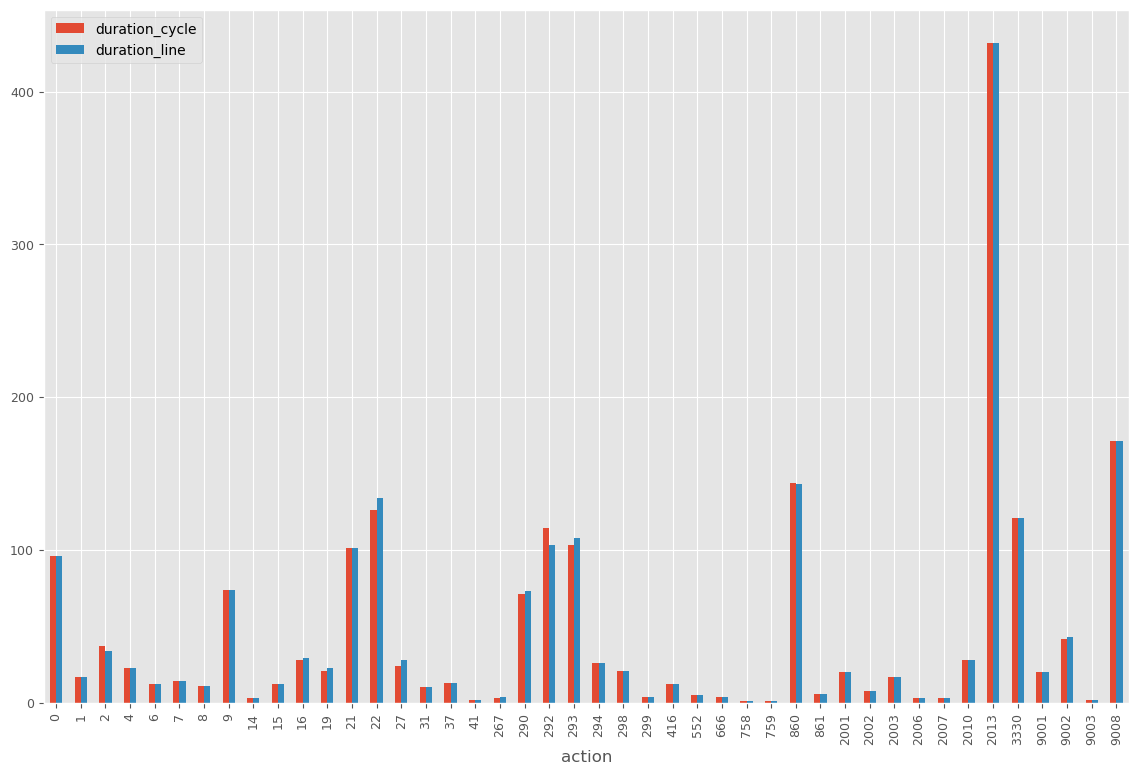

In [103]:
# визуализируем данные
df_duration.plot(
    x="action",
    y=["duration_cycle", "duration_line"],
    kind="bar",
    rot=90,
    fontsize=9,
    figsize=(14, 9),
)
plt.show()

In [94]:
corr = df_duration["duration_cycle"].corr(df_duration["duration_line"])
rmse = math.sqrt(
    mean_squared_error(df_duration["duration_cycle"], df_duration["duration_line"])
)
print(f"Коэффициент линейной корреляции Пирсона: {corr.round(3)}")
print(f"Среднее расхождение результатов: {df_duration.delta_time.mean().round(2)} сек")
print(f"Среднеквадратичная ошибка: {rmse}")

Коэффициент линейной корреляции Пирсона: 0.999
Среднее расхождение результатов: -0.17 сек
Среднеквадратичная ошибка: 2.3991002101166634


Осталось понять, почему всё так произошло?
![](https://ua.edufuture.biz/wp-content/uploads/2019/04/2-9.jpg)